In [2]:
import pandas as pd
import numpy as np
import random as rd
import os
import glob
#%run -i qadconnect.py
import datetime as dt
#%run -i helper_20150211.py
%pylab inline
import matplotlib.finance as fin
#%run -i myfunctions.py

def get_im_sub(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

#receives a list of dates and outputs a list of 3rd fridays exept of the 1st month (double check behavior if dates in 1st month not complete)
def get_3rd_fridays(date_list):
    dates = pd.DatetimeIndex(date_list)
    isfriday=(dates.weekday==4)
    ismonthstart=(dates.day[0:len(dates)-1]>dates.day[1:len(dates)])
    dates1=dates[1:len(dates)]
    monthstarts=dates1[ismonthstart]
    fridays=dates[isfriday]
    fridaystokeep=fridays>=monthstarts[0]
    fridays=fridays[fridaystokeep]

    thirdfriday=[]
    for i in range(0,len(monthstarts)-1):
        isfridaysofthemonth=(fridays>=monthstarts[i]) & (fridays<monthstarts[i+1])
        fridaysofthemonth=fridays[isfridaysofthemonth]
        if len(fridaysofthemonth)>=2:
            thirdfriday.append(fridaysofthemonth[2])
    return thirdfriday

def rollCorr(a,b,window):
    rollCorr=np.zeros((len(a)))
    window=window-1
    for i in range(window,len(a)):
        rollCorr[i]=myCorr(a[i-window:i+1],b[i-window:i+1])
    return rollCorr

def myCorr(a,b):
    l=len(a)
    cov=sum(a*b)/l-sum(a)/l*sum(b)/l  
    vara=sum(a*a)/l-sum(a)/l*sum(a)/l   
    varb=sum(b*b)/l-sum(b)/l*sum(b)/l
    return float(cov/(np.sqrt(vara)*np.sqrt(varb)))

#received a df with column0:weight ;column1=cap; returns df with additional column2:capfactor; colum3:cappedwgt
#reindexes the df starting with 1
def calccapfacs(df_comp): 
    df_comp = df_comp.sort(df_comp.columns[0],ascending=False)
    df_comp.index = range(1,len(df_comp)+1)
    df_comp['capfactor']=1
    if sum(df_comp.iloc[:,1])<=1.:   
        df_comp['cappedwgt'] = 1. / len(df_comp) #equal weight
    else:
        df_comp['cappedwgt'] = df_comp.iloc[:,0]
        while len(df_comp[df_comp.cappedwgt > df_comp.iloc[:,1]]) > 0:
            dblToCap = df_comp[df_comp.cappedwgt >= df_comp.iloc[:,1]].iloc[:,1].sum()
            weightsnocap = df_comp[df_comp.cappedwgt < df_comp.iloc[:,1]].cappedwgt.sum()
            dblDistFactor = weightsnocap / (1 - dblToCap)
            for index, row in df_comp.iterrows():
                if row['cappedwgt'] >= row[1]: 
                    df_comp.loc[index,'cappedwgt'] = dblDistFactor * row[1]
            dblcappedsum = df_comp.cappedwgt.sum()
            df_comp['cappedwgt'] = df_comp['cappedwgt'] / dblcappedsum
    df_comp['capfactor']=(df_comp['cappedwgt']/df_comp.iloc[:,0])/max(df_comp['cappedwgt']/df_comp.iloc[:,0])
    return df_comp

#calculates weights and capping factors minimizing the squared sum of the deviation with the intended weights
#received a df with column0:weight (used as initial guess) ;column1=cap; 
#returns df with additional column2:capfactor; colum3:cappedwgt
#method met_ =1: TNC (Truncated Newton's algorithm); met_ =2: L-BFGS-B (limited memory BFGS)
#reindexes the df starting with 1
def cap_with_min_devs(dfx, met_=1):
    from scipy.optimize import minimize
    dfx['capfactor']=1.
    options={1 : 'TNC',
         2 : 'L-BFGS-B'} #for methods 1 and 2
    def wgtfun(x):
        return sum(x-wt)**2
    x = np.array(dfx.iloc[:,0])
    wt = x
    b = [(0.,dfx.iloc[i,1]) for i in range(len(dfx))]
    c = ({'type':'eq', 'fun': lambda x: sum(x)-1. })  #methods TNC and L-BFGS-B cannot handle constraints
    
    res=minimize(wgtfun, x , method=options[met_], bounds=b, constraints=c)
    dfx['cappedwgt']=res.x
    dfx['capfactor']=(dfx['cappedwgt']/dfx.iloc[:,0])/max(dfx['cappedwgt']/dfx.iloc[:,0])
    return dfx

Populating the interactive namespace from numpy and matplotlib


In [4]:
#mean var
#get data
loc1='D:/Anto/Estudio/Python/'
dfmain=pd.read_excel(loc1+'prod.xlsx')
pd.to_datetime(dfmain.index, format='%d.%m.%Y', dayfirst=True)
#dfmain=dfmain[dfmain.index > dt.date(2011,3,24)]
dfmain=dfmain.iloc[3966:,:]
#dfmain=dfmain/dfmain.iloc[0,:]*100 #rebase
len(dfmain)
#dfmain

988

284


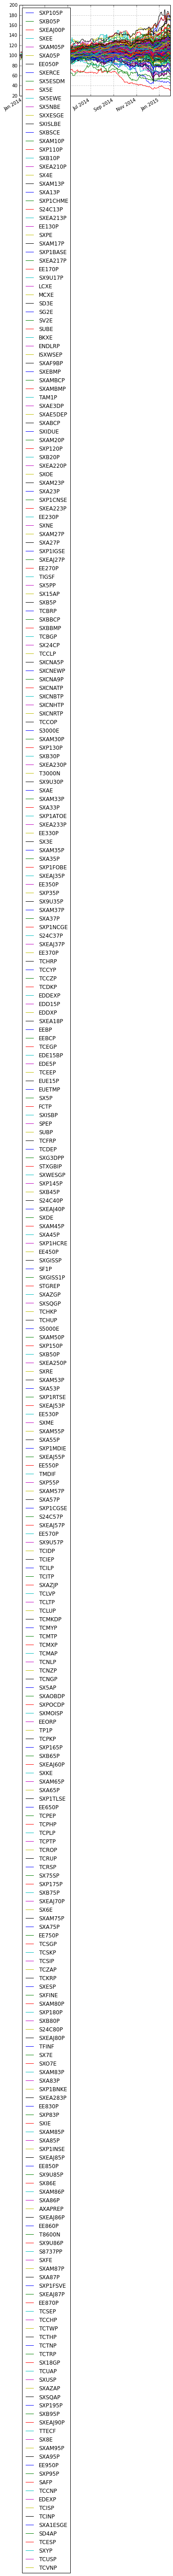

In [4]:
loc='D:/Anto/Estudio/Python/'
dfin=pd.read_excel(loc+'index_symbols.xlsx', sheetname='300')
dfin=dfin[['Symbol','ICB','Full Name']]
#dfin.head()

dfmain=pd.read_excel(loc+'h_prod.xlsx')
pd.to_datetime(dfmain.index, format='%d.%m.%Y', dayfirst=True)
dfmain=dfmain.iloc[4683:,:]
dfmain=dfmain/dfmain.iloc[0,:]*100 #rebase
print len(dfmain)
dfmain.plot()

In [6]:
#calculate returns
#dfmain=dfmain.iloc[:6,:]
dfmain.fillna(method='pad', inplace=True)
returns=log(array(dfmain.iloc[1:len(dfmain),:])/array(dfmain.iloc[0:len(dfmain)-1,:])) #log returns
dfr=pd.DataFrame(returns)
dfr.index=dfmain.index[1:]
dfr.columns=dfmain.columns

#calculate covarianc matrix
covs= np.cov(returns.T)*252
dfcov=pd.DataFrame(covs)
#dfcorr=pd.DataFrame(np.corrcoef(returns.T))
dfcov.columns=dfmain.columns
dfcov.index=dfmain.columns
variances= [np.var(np.array(dfr.iloc[:,i]), ddof=1)*252 for i in range(len(dfr.columns))] #checking the variances in the main diagonal
volas= [np.std(np.array(dfr.iloc[:,i]), ddof=1)*np.sqrt(252) for i in range(len(dfr.columns))]
#dfcov

In [6]:
lvwgt=(array(volas)**(-1))/sum(array(volas)**(-1)) #low risk weighted
list(lvwgt)
a_returns=array([sum(returns.T[i]/len(dfr)) for i in range(len(dfr.columns))])*252 #annualized returns

#portfolio return based on low risk weights
return_p = np.dot(lvwgt,a_returns)
#portfolio variance based on low risk
variance_p = np.dot(lvwgt,np.dot(covs,lvwgt))

rskfree=0.05
sharpe_rts=list((a_returns-rskfree)/list(volas)) #sharpe ratio

In [ ]:
#sector weight constraint
def ind_exp_constraint(, i_max):
    cons=1
    return cons

cons=ind_exp_constraint(20.)
cons

In [16]:
#min var optimization
w_max=0.045
H=50.

from scipy.optimize import minimize
def port_var(w):
    return np.dot(w,np.dot(covs,w))

b_ = [(0.,w_max) for i in range(len(dfr.columns))]
c_ = ({'type':'eq', 'fun': lambda w: np.dot(w,w)-1./H},
    {'type':'eq', 'fun': lambda w: sum(w)-1.}) 
w0=ones(len(dfr.columns))/len(dfr.columns)

optiwgts = minimize(port_var, w0, method='SLSQP', bounds=b_, constraints=c_)

dfopti=pd.DataFrame(optiwgts.x)
dfopti=np.round(dfopti,7)
dfopti['Symbol']=dfr.columns
cols=dfopti.columns.tolist()
dfopti=dfopti[cols[-1:] + cols[:-1]] #rearrange column order
dfopti=dfopti.rename(columns={dfopti.columns[1]:'weight'})
dfopti=dfopti.sort('weight', ascending=False)

dfopti=pd.merge(dfopti, dfin, how='left', on='Symbol')
dfopti.index=dfopti.Symbol
del dfopti['Symbol']
dfopti.index.name=None
dfopti.head()

,weight,ICB,Full Name
TCMAP,0.045000,5000,STOXX Morocco Total Market
TCMTP,0.041257,5000,STOXX Malta Total Market
TCHRP,0.039370,3000,STOXX Croatia Total Market
TCMKDP,0.036003,5000,STOXX Macedonia Total Market
TCISP,0.035669,9000,STOXX Iceland Total Market


In [165]:
indendpos=[]
indx=np.array(range(0,len(dfin)-1,1))
indendpos=np.array(dfin.ICB[0:len(dfin)-1]==dfin.ICB[1:len(dfin)])
indendposix=list(indx[indendpos==0])
indendposix.append(len(dfin)-1)
#{'type':'eq', 'fun': lambda w: sum(w)-1.}


b_ = [(0.,w_max) for i in range(len(dfr.columns))]
c_ = ({'type':'eq', 'fun': lambda w: np.dot(w,w)-1./H},
    {'type':'eq', 'fun': lambda w: sum(w)-1.}) 
#cc_=list()

def fun1(w):
    return sum(w[0:indendposix[0]])-0.1

def fun2(w):
    return sum(w[indendposix[0]+1:indendpos[1]])-0.1  

#for i in range(len(indendposix
#cc_.append({'type':'eq', 'fun': fun1})
#cc_.append({'type':'eq', 'fun': fun2})    
#cc_.append({'type':'eq', 'fun': lambda w: np.dot(w,w)-1./H})
#cc_.append({'type':'eq', 'fun': lambda w: sum(w)-1.})

#cc_=({'type':'eq', 'fun': fun1}, {'type':'eq', 'fun': fun2},{'type':'eq', 'fun': lambda w: np.dot(w,w)-1./H},{'type':'eq', 'fun': lambda w: sum(w)-1.})
cc_=({'type':'eq', 'fun': lambda w: sum(w[0:indendposix[0]])-0.2},
     #{'type':'eq', 'fun': lambda w: sum(w[indendposix[0]+1:indendpos[1]])-0.2},
     {'type':'eq', 'fun': lambda w: np.dot(w,w)-1./H},
     {'type':'eq', 'fun': lambda w: sum(w)-1.})

print cc_
w0=ones(len(dfr.columns))/len(dfr.columns)

optiwgts = minimize(port_var, w0, method='SLSQP', bounds=b_, constraints=cc_)
optiwgts.x

dfopti=pd.DataFrame(optiwgts.x)
dfopti=np.round(dfopti,7)
dfopti['Symbol']=dfr.columns
cols=dfopti.columns.tolist()
dfopti=dfopti[cols[-1:] + cols[:-1]] #rearrange column order
dfopti=dfopti.rename(columns={dfopti.columns[1]:'weight'})
dfopti=dfopti.sort('weight', ascending=False)

dfopti=pd.merge(dfopti, dfin, how='left', on='Symbol')
dfopti.index=dfopti.Symbol
del dfopti['Symbol']
dfopti.index.name=None
print sum(optiwgts.x[0:indendposix[0]])
dfopti

({'fun': <function <lambda> at 0x0000000010770358>, 'type': 'eq'}, {'fun': <function <lambda> at 0x0000000010770748>, 'type': 'eq'}, {'fun': <function <lambda> at 0x0000000010760EB8>, 'type': 'eq'})
0.2


,weight,ICB,Full Name
TCMAP,0.042092,5000,STOXX Morocco Total Market
TCMTP,0.038012,5000,STOXX Malta Total Market
TCISP,0.034500,9000,STOXX Iceland Total Market
TCHRP,0.034416,3000,STOXX Croatia Total Market
TCMKDP,0.033245,5000,STOXX Macedonia Total Market
TCBGP,0.031125,2000,STOXX Bulgaria Total Market
TCRSP,0.030543,6000,STOXX Serbia Total Market
TCTNP,0.030003,8000,STOXX Tunisia Total Market
SXAM05P,0.028624,1,STOXX Americas 1200 Oil & Gas
TCLTP,0.028525,5000,STOXX Lithuania Total Market


In [166]:
print np.dot(optiwgts.x,optiwgts.x)
print sum(optiwgts.x)
print(1/H)
print sum(optiwgts.x[0:indendposix[0]])
print sum(optiwgts.x[indendposix[0]+1:indendposix[1]])

#dfr.head()

0.0200003344116
1.0
0.02
0.2
0.000498788429649


In [143]:
#{'type':'eq', 'fun': lambda w: sum(w)-1.}
optiwgts.x[0:indendposix[0]]

array([ 0.00333333,  0.00333333,  0.00333333,  0.00333333,  0.00333333,
        0.00333333,  0.00333333,  0.00333333,  0.00333333,  0.00333333,
        0.00333333,  0.00333333,  0.00333333])

In [77]:
#{'type':'eq', 'fun': lambda w: sum(w)-1.}

def f_industry:
#sector weight constraint
def ind_exp_constraint(, i_max):
    cons=1
    return cons

cons=ind_exp_constraint(20.)
cons

SyntaxError: invalid syntax (<ipython-input-77-646d638cda1c>, line 3)

In [20]:
dftemp=pd.DataFrame({'symbol':dfr.columns,'ICB':dfin.ICB})
print np.unique(list(dfin.ICB))
dftemp



[   1 1000 2000 3000 4000 5000 6000 7000 8000 9000]


,ICB,symbol
0,1,SXP105P
1,1,SXB05P
2,1,SXEAJ00P
3,1,SXEE
4,1,SXAM05P
5,1,SXA05P
6,1,EE050P
7,1,SXERCE
8,1,SX5ESDM
9,1,SX5E
